In [39]:
# Directory
import os, zipfile, shutil

# Preprocessing and Layer
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras_preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout, Conv2D

# Plotting
import matplotlib.pyplot as plt

In [40]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"aininurpadilah","key":"8c8e950a99729c19379926d1bd0cab29"}'}

In [42]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [43]:
!kaggle datasets download -d prasunroy/natural-images

100% 342M/342M [00:17<00:00, 20.0MB/s]
100% 342M/342M [00:17<00:00, 20.5MB/s]


In [45]:
local_zip = '/content/natural-images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [49]:
#Defines the directory name for the train data and validation data.
main_dir = os.path.join('/content/data/natural_images')
print(os.listdir(main_dir))

['fruit', 'motorbike', 'flower', 'person', 'dog', 'car', 'cat', 'airplane']


In [50]:
ignore_dir = ['motorbike', 'flower', 'dog', 'cat', 'airplane']

for dir in ignore_dir:
  path = os.path.join(main_dir, dir)
  shutil.rmtree(path)

print(os.listdir(main_dir))

['fruit', 'person', 'car']


In [51]:
from PIL import Image
samples = 0

for x in os.listdir(main_dir):
  dir = os.path.join('/content/data/natural_images', x)
  y = len(os.listdir(dir))
  print(x+' :', y)
  samples = samples + y
  
  image_name = os.listdir(dir)
  for z in range(3):
    image_path = os.path.join(dir, image_name[z])
    image = Image.open(image_path)
    print(image.size)
  print()


print('Total Sample : ', samples)

fruit : 1000
(100, 100)
(100, 100)
(100, 100)

person : 986
(256, 256)
(256, 256)
(256, 256)

car : 968
(100, 100)
(100, 100)
(100, 100)

Total Sample :  2954


In [52]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.2)

In [53]:
train_generator = train_datagen.flow_from_directory(
    main_dir,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
    subset='training')
 
validation_generator = train_datagen.flow_from_directory(
    main_dir,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
    subset='validation')

Found 2364 images belonging to 3 classes.
Found 590 images belonging to 3 classes.


In [54]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') and logs.get('val_accuracy') > 0.92):
      print("\n Sorry, data training was stopped because the accuracy rate was above 92%!")
      self.model.stop_training = True

callbacks = Callback()

In [55]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3))),
model.add(MaxPooling2D(2, 2)),

model.add(Conv2D(64, (3,3), activation='relu')),
model.add(MaxPooling2D(2,2)),

model.add(Conv2D(128, (3,3), activation='relu')),
model.add(MaxPooling2D(2,2)),

model.add(Conv2D(128, (3,3), activation='relu')),
model.add(MaxPooling2D(2,2)),

model.add(Flatten()),

model.add(Dense(512, activation='relu')),
model.add(Dense(3, activation='softmax')),

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [56]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [57]:
history = model.fit(
    train_generator,
    epochs= 100,
    validation_data=validation_generator,
    verbose=2,
    callbacks=[callbacks])

Epoch 1/100
19/19 - 21s - loss: 0.5594 - accuracy: 0.7555 - val_loss: 0.2465 - val_accuracy: 0.8949 - 21s/epoch - 1s/step
Epoch 2/100

 Sorry, data training was stopped because the accuracy rate was above 92%!
19/19 - 17s - loss: 0.1033 - accuracy: 0.9645 - val_loss: 0.0635 - val_accuracy: 0.9797 - 17s/epoch - 885ms/step


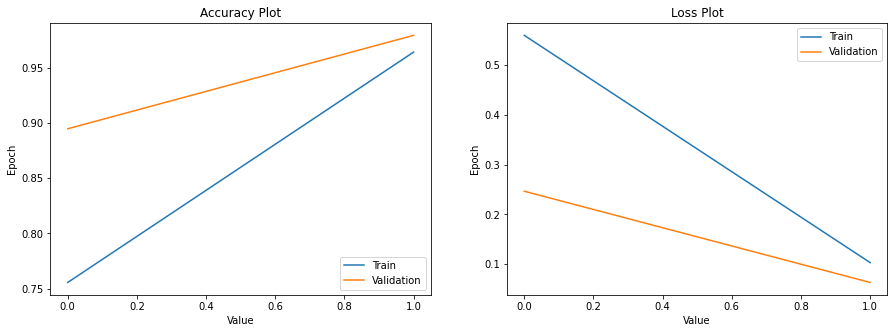

In [60]:
figure = plt.figure(figsize = (15, 5))

figure.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Plot')
plt.xlabel('Value')
plt.ylabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')

figure.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Plot')
plt.xlabel('Value')
plt.ylabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')

In [58]:
save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

In [59]:
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()
     
with tf.io.gfile.GFile('model_image_classification.tflite', 'wb') as f:
  f.write(tflite_model)